In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import arviz as az
import astropy.io.ascii as aia
import pystan
import scipy.stats as ss
import seaborn as sns
from tqdm import tqdm

sns.set_context('notebook')
sns.set_palette('colorblind')
sns.set_style('ticks')

In [3]:
model = pystan.StanModel(file='AlsingReconstruction.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c615398d77f3b846b66e8f97823d20f9 NOW.


This is Table 1 from [Alsing, Silva, & Berti (2018)](http://dx.doi.org/10.1093/mnras/sty1065)

In [4]:
t = aia.read('Table1.tex', delimiter='&')
t.show_in_notebook()

idx,name,type,f [$\msol$],$\mt$ [$\msol$],q,$\mp$ [$\msol$],reference\tabularnewline
0,4U1700-377,x-ray/optical,--,--,--,1.96$\pm$0.19,\citet{Falanga2015}\tabularnewline
1,Cyg X-2,x-ray/optical,--,--,--,1.71$\pm$0.21,\citet{Casares2009}\tabularnewline
2,SMC X-1,x-ray/optical,--,--,--,1.21$\pm$0.12,\citet{Falanga2015}\tabularnewline
3,Cen X-3,x-ray/optical,--,--,--,1.57$\pm$0.16,\citet{Falanga2015}\tabularnewline
4,XTE J2123-058,x-ray/optical,--,--,--,1.53$\pm$0.42,\citet{Gelino2002}\tabularnewline
5,4U 1822-371,x-ray/optical,--,--,--,1.96$\pm$0.36,\citet{MunozDarias2005}\tabularnewline
6,OAO 1657-415,x-ray/optical,--,--,--,1.74$\pm$0.3,\citet{Falanga2015}\tabularnewline
7,J013236.7+303228,x-ray/optical,--,--,--,2.0$\pm$0.4,\citet{Bhalerao2012}\tabularnewline
8,Vela X-1,x-ray/optical,--,--,--,2.12$\pm$0.16,\citet{Falanga2015}\tabularnewline
9,4U1538-522,x-ray/optical,--,--,--,1.02$\pm$0.17,\citet{Falanga2015}\tabularnewline


Note that we by-hand include [Cromartie, et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020NatAs...4...72C/abstract) at $m_1 = 2.14 \pm 0.1 \, M_\odot$.

In [5]:
gaussian_strs = t.columns[5][~t.columns[5].mask]
gaussian_means = array([float(g.split(r'$\pm')[0]) for g in gaussian_strs])
gaussian_stds = array([float(g.split(r'$\pm$')[1]) for g in gaussian_strs])


gaussian_means = np.append(gaussian_means, 2.14)
gaussian_stds = np.append(gaussian_stds, 0.1)

In [6]:
def f_float(x):
    try:
        return float(x)
    except ValueError:
        return float(x[1:-2].replace(r'\times10^{', 'e'))        

In [7]:
qmask = t.columns[4].mask
f_q = array([f_float(f) for f in t.columns[2][~qmask]])
q_means = array([float(q.split(r'$\pm$')[0]) for q in t.columns[4][~qmask]])
q_stds = array([float(q.split(r'$\pm$')[1]) for q in t.columns[4][~qmask]])

In [8]:
mtmask = t.columns[3].mask
f_mt = array([f_float(f) for f in t.columns[2][~mtmask]])
mt_means = array([float(mt.split(r'$\pm$')[0]) for mt in t.columns[3][~mtmask]])
mt_stds = array([float(mt.split(r'$\pm$')[1]) for mt in t.columns[3][~mtmask]])

In [9]:
data = {
    'n_gaussian': len(gaussian_means),
    'n_mt': len(mt_means),
    'n_q': len(q_means),
    
    'mp_mean': gaussian_means,
    'mp_std': gaussian_stds,
    
    'f_mt': f_mt,
    'mt_mean': mt_means,
    'mt_std': mt_stds,
    
    'f_q': f_q,
    'q_mean': q_means,
    'q_std': q_stds
}

In [10]:
fit = az.from_pystan(model.sampling(data=data, control={'adapt_delta': 0.95}))
az.to_netcdf(fit, 'ar.nc')

'ar.nc'

In [11]:
fit = az.from_netcdf('ar.nc')

In [12]:
az.summary(fit, var_names=['mmax', 'As', 'mus', 'sigmas', 'mp_draw'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mmax,2.381,0.363,1.933,3.049,0.011,0.008,1115.0,1115.0,935.0,1565.0,1.0
As[0],0.643,0.092,0.459,0.801,0.002,0.002,1546.0,1505.0,1504.0,2163.0,1.0
As[1],0.357,0.092,0.199,0.541,0.002,0.002,1546.0,1546.0,1504.0,2163.0,1.0
mus[0],1.352,0.020,1.315,1.390,0.000,0.000,2654.0,2640.0,2715.0,2498.0,1.0
mus[1],1.880,0.224,1.543,2.357,0.008,0.006,708.0,682.0,859.0,837.0,1.0
sigmas[0],0.080,0.017,0.049,0.115,0.000,0.000,1647.0,1647.0,1644.0,2114.0,1.0
sigmas[1],0.300,0.132,0.093,0.554,0.005,0.003,817.0,817.0,802.0,1602.0,1.0
mp_draw,1.491,0.253,1.151,2.009,0.004,0.003,3737.0,3737.0,3775.0,3827.0,1.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11e9eb310>,
      dtype=object)

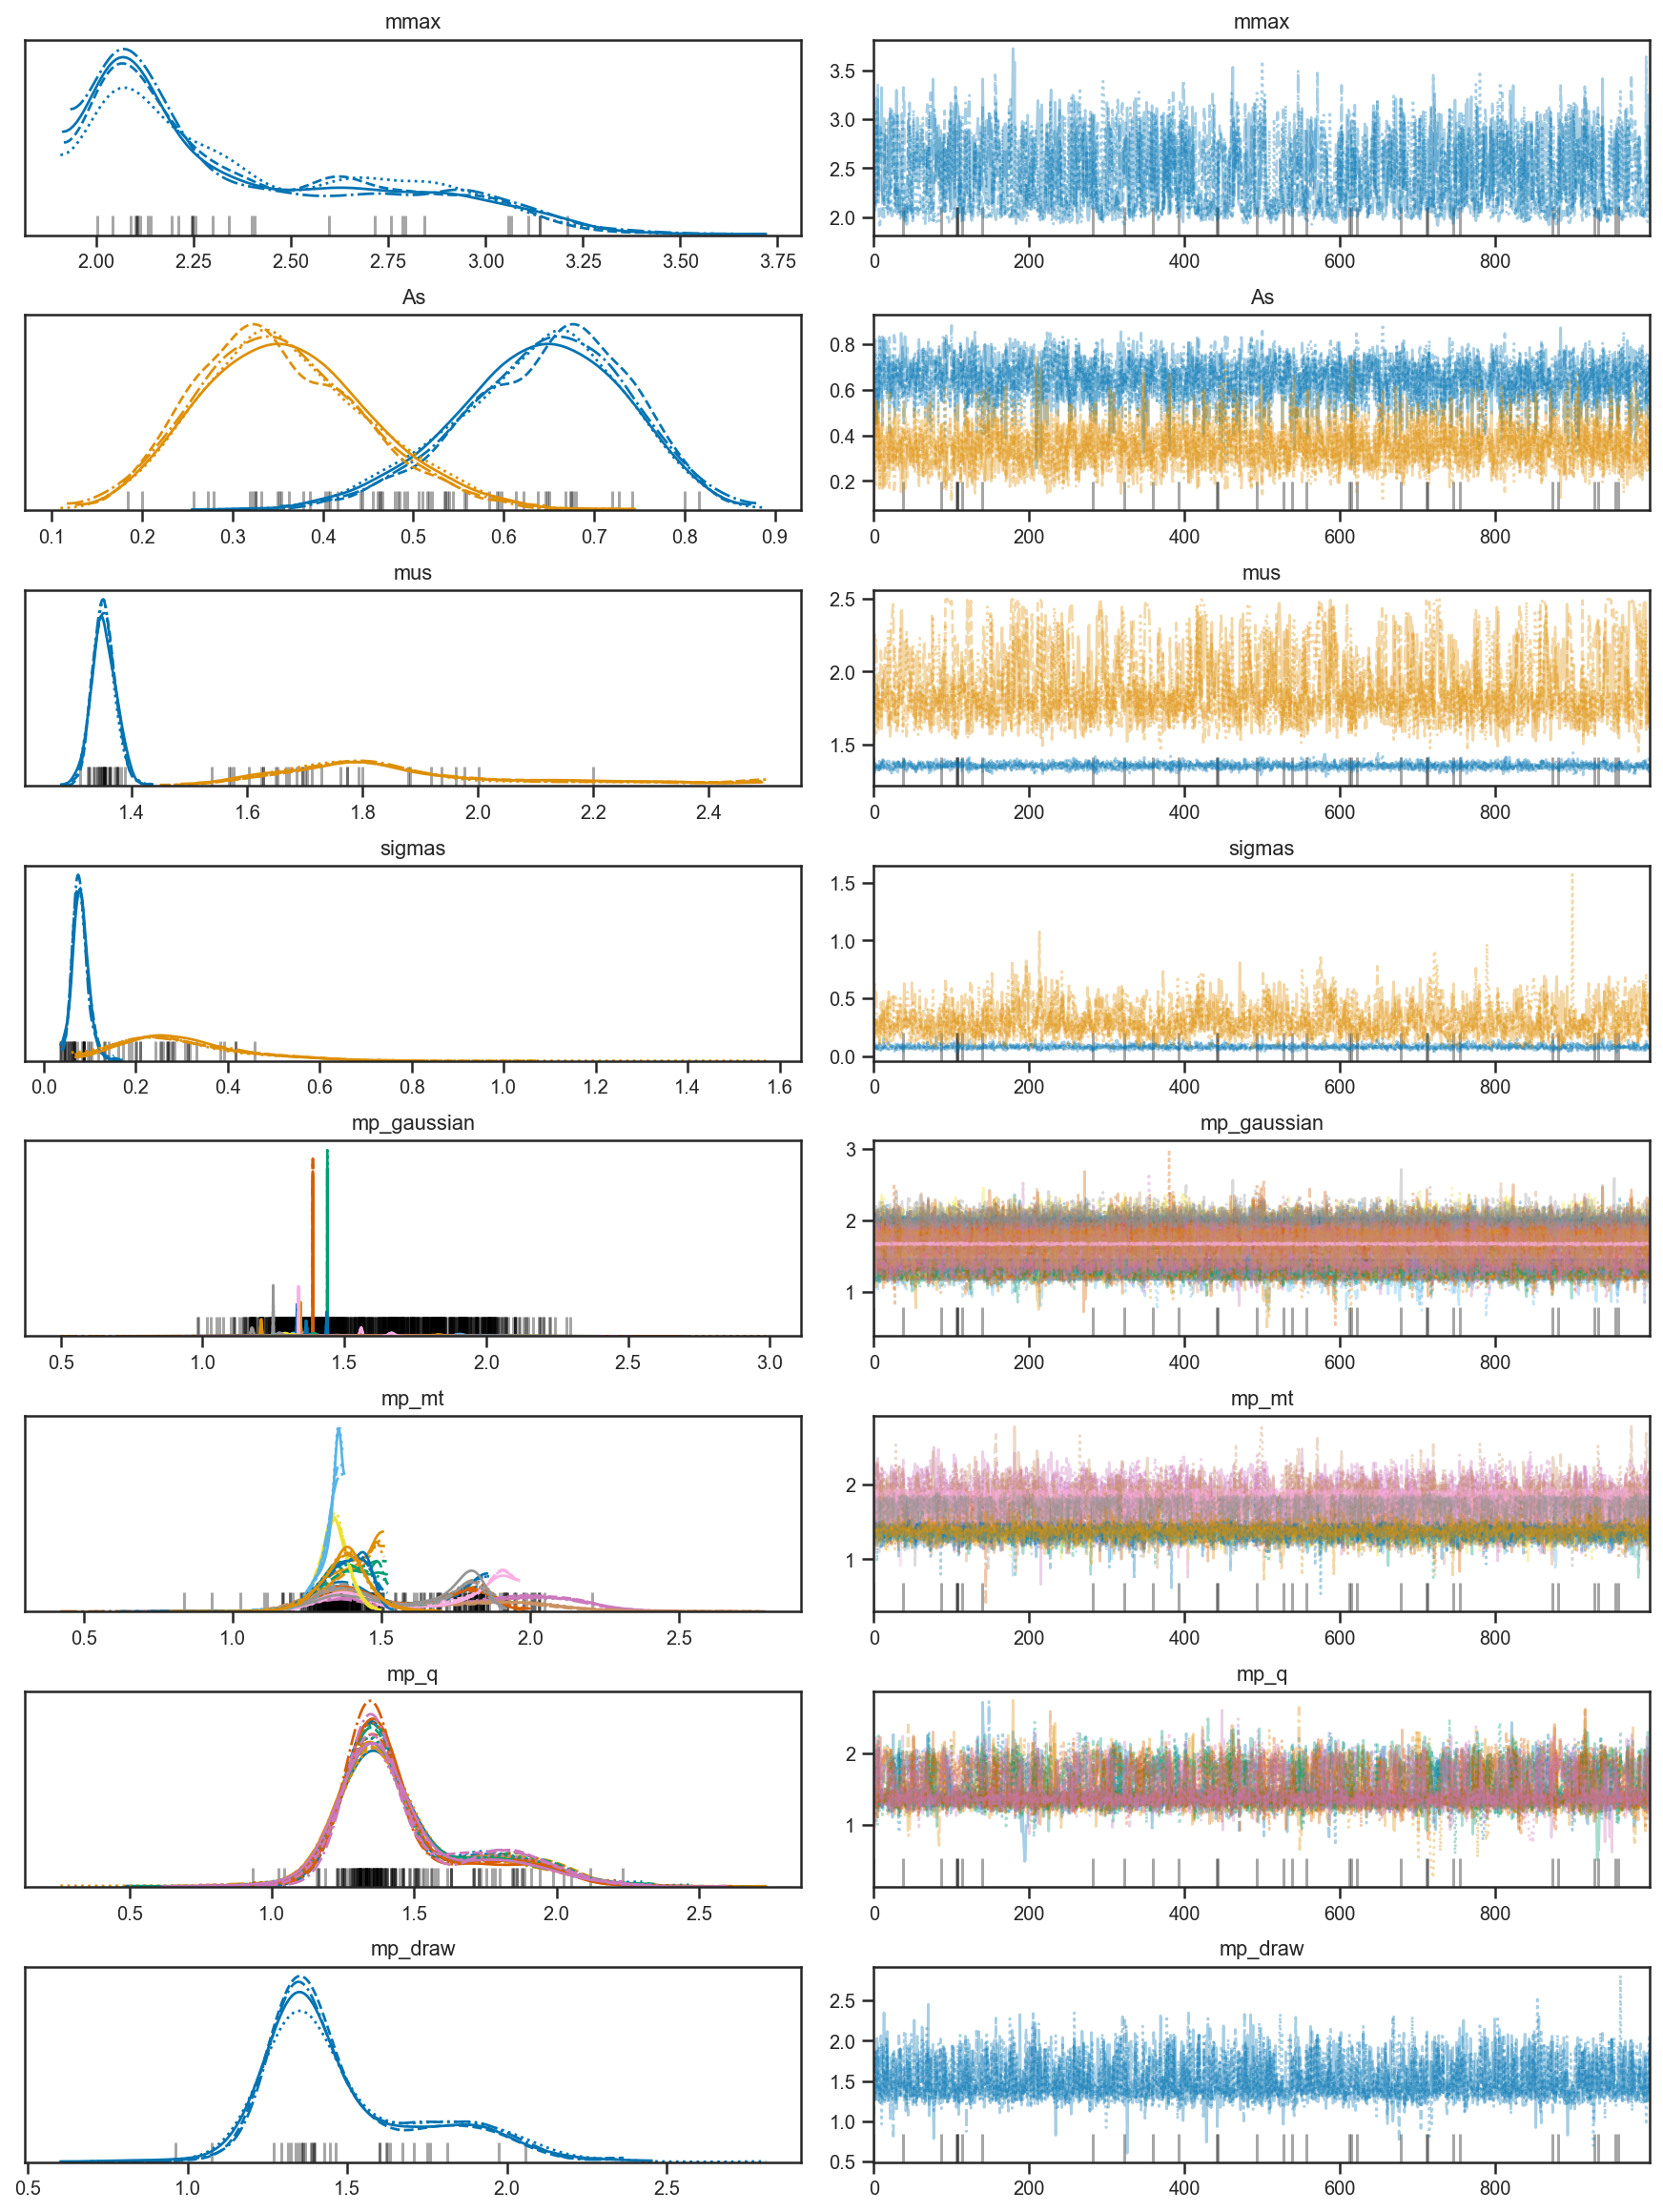

In [13]:
az.plot_trace(fit, compact=True, var_names=['mmax', 'As', 'mus', 'sigmas', 'mp_gaussian', 'mp_mt', 'mp_q', 'mp_draw'])

Text(0, 0.5, '$p\\left( m_\\mathrm{max} \\right)$')

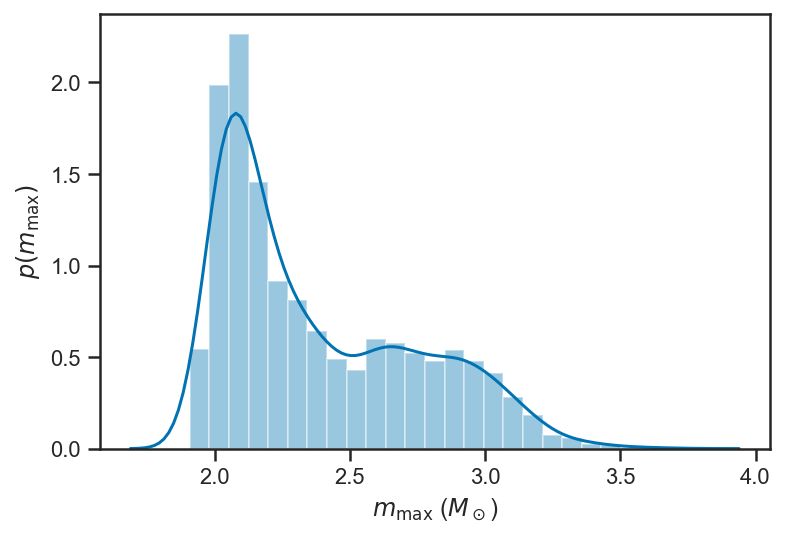

In [14]:
sns.distplot(fit.posterior.mmax.values.flatten())
xlabel(r'$m_\mathrm{max}$ ($M_\odot$)')
ylabel(r'$p\left( m_\mathrm{max} \right)$')

(1.0, 2.5, 0.0, 3.589714449966334)

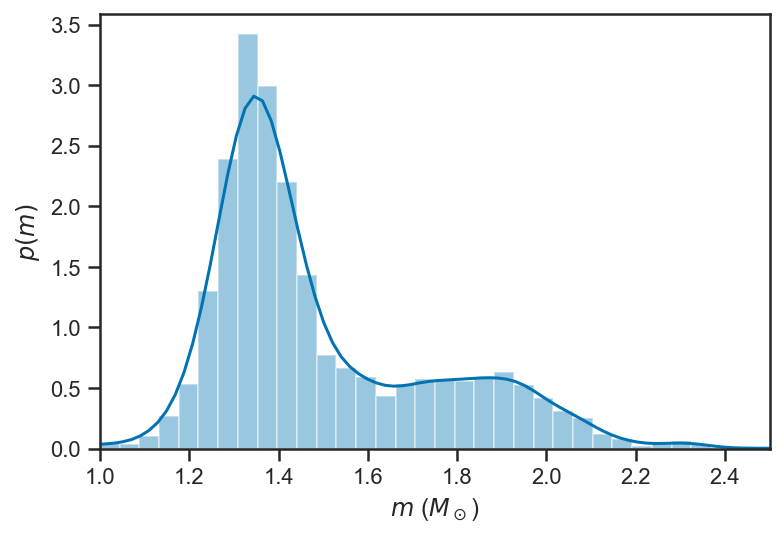

In [15]:
sns.distplot(fit.posterior.mp_draw)
xlabel(r'$m$ ($M_\odot$)')
ylabel(r'$p(m)$')
axis(xmin=1.0, xmax=2.5)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12026efd0>,
      dtype=object)

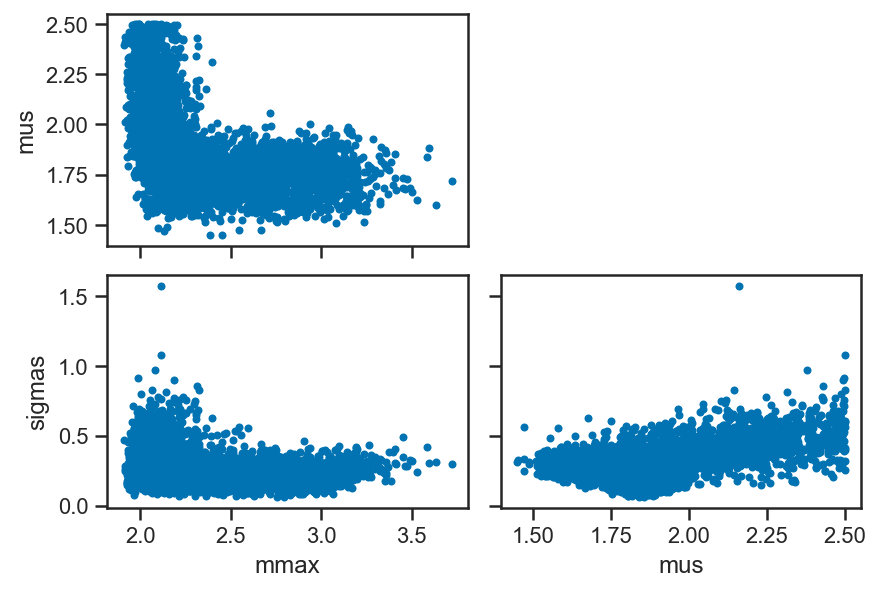

In [16]:
az.plot_pair(fit, var_names=['mmax', 'mus', 'sigmas'], coords={'mus_dim_0': 1, 'sigmas_dim_0': 1})

In [17]:
def plot_one_pdf(ms, mmax, A, mu1, mu2, sigma1, sigma2, norm1, norm2, alpha):
    B = 1-A
    g1 = ss.norm(loc=mu1, scale=sigma1)
    g2 = ss.norm(loc=mu2, scale=sigma2)
        
    ps = A*g1.pdf(ms)/norm1 + B*g2.pdf(ms)/norm2
    ps[ms>mmax] = 0.0

    plot(ms, ps, '-k', alpha=alpha)
    

def plot_dists(fit, Nplot=128):
    ms = linspace(1, 2.5, 128)

    pts = column_stack((fit.posterior.As[:,:,0].values.flatten(),
                        fit.posterior.mus.values.reshape((-1, 2)),
                        fit.posterior.sigmas.values.reshape((-1, 2)))).T
    k = ss.gaussian_kde(pts)
    i, j = unravel_index(argmax(k(pts)), fit.posterior.mmax.shape)
    
    plot_one_pdf(ms, fit.posterior.mmax[i,j].values, 
                 fit.posterior.As[i,j,0].values,
                 fit.posterior.mus[i,j,0].values,
                 fit.posterior.mus[i,j,1].values,
                 fit.posterior.sigmas[i,j,0].values,
                 fit.posterior.sigmas[i,j,1].values,
                 exp(fit.posterior.log_norms[i,j,0].values),
                 exp(fit.posterior.log_norms[i,j,1].values),
                 1.0)
    
    for i in tqdm(range(Nplot)):
        c = np.random.choice(fit.posterior.chain)
        d = np.random.choice(fit.posterior.draw)
        
        A, B = fit.posterior.As[c,d,:].values
        mu1, mu2 = fit.posterior.mus[c,d,:].values
        s1, s2 = fit.posterior.sigmas[c,d,:].values
        mm = fit.posterior.mmax[c,d].values
        n1, n2 = exp(fit.posterior.log_norms[c,d,:].values)
        
        plot_one_pdf(ms, mm, A, mu1, mu2, s1, s2, n1, n2, 3/float(Nplot))
        
    sns.kdeplot(fit.posterior.mp_draw.values.flatten())
    axis(xmin=1, xmax=2.5)
    xlabel(r'$m$ ($M_\odot$)')
    ylabel(r'$p(m)$')

100%|██████████| 128/128 [00:02<00:00, 61.29it/s]


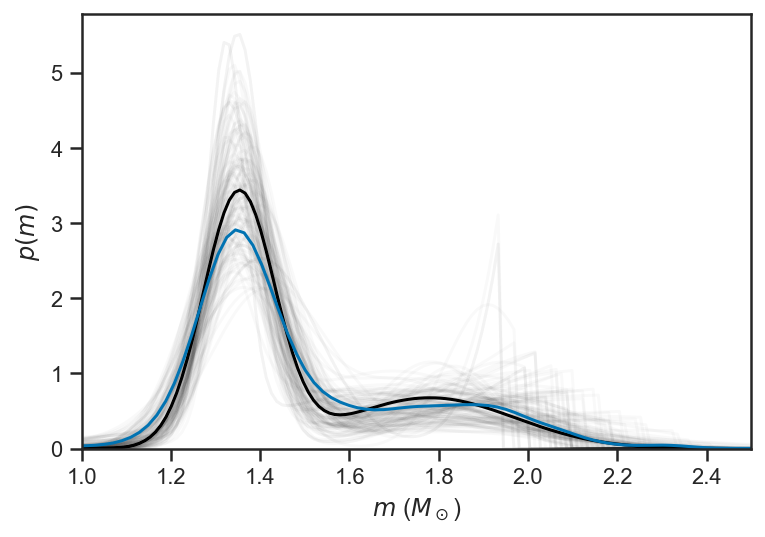

In [18]:
plot_dists(fit)